In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import yaml

In [8]:
from models.unet import UNet
from models.deeplab_v3p import DeepLabV3Plus
from torchinfo import summary
import os

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, model_name = UNet(), "UNet_22-11-2024_20-20-24.pth"
# model, model_name = DeepLabV3Plus(), "DeepLabV3Plus_22-11-2024_21-04-50.pth"
path = os.path.join("", 'bin', model_name)
model.load_state_dict(torch.load(path, weights_only=True))
model.to(device)
model.eval()
summary(model, input_size=(config["Training"]["BATCH_SIZE"], 3, *config["Training"]["IMAGE_SIZE"]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 1, 256, 256]          --
├─ModuleList: 1-1                        --                        --
│    └─DoubleConv: 2-1                   [8, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [8, 64, 256, 256]         38,976
│    └─DoubleConv: 2-2                   [8, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [8, 128, 128, 128]        221,952
│    └─DoubleConv: 2-3                   [8, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [8, 256, 64, 64]          886,272
│    └─DoubleConv: 2-4                   [8, 512, 32, 32]          --
│    │    └─Sequential: 3-4              [8, 512, 32, 32]          3,542,016
├─DoubleConv: 1-2                        [8, 1024, 16, 16]         --
│    └─Sequential: 2-5                   [8, 1024, 16, 16]         --
│    │    └─Conv2d: 3-5                  [8, 1024, 16, 16]      

In [15]:
from dataset.transforms import get_val_transforms
from dataset.image_dataset import ImageDataset

np.random.seed(0)
dataset = ImageDataset('data/test', transforms=get_val_transforms())

def get_img_mask():
    imgs, masks = [], []
    for i in range(4):
        idx = np.random.randint(0, len(dataset))
        img, mask = dataset[idx]
        imgs.append(img.to(device))
        masks.append(mask.to(device))
    return imgs, masks

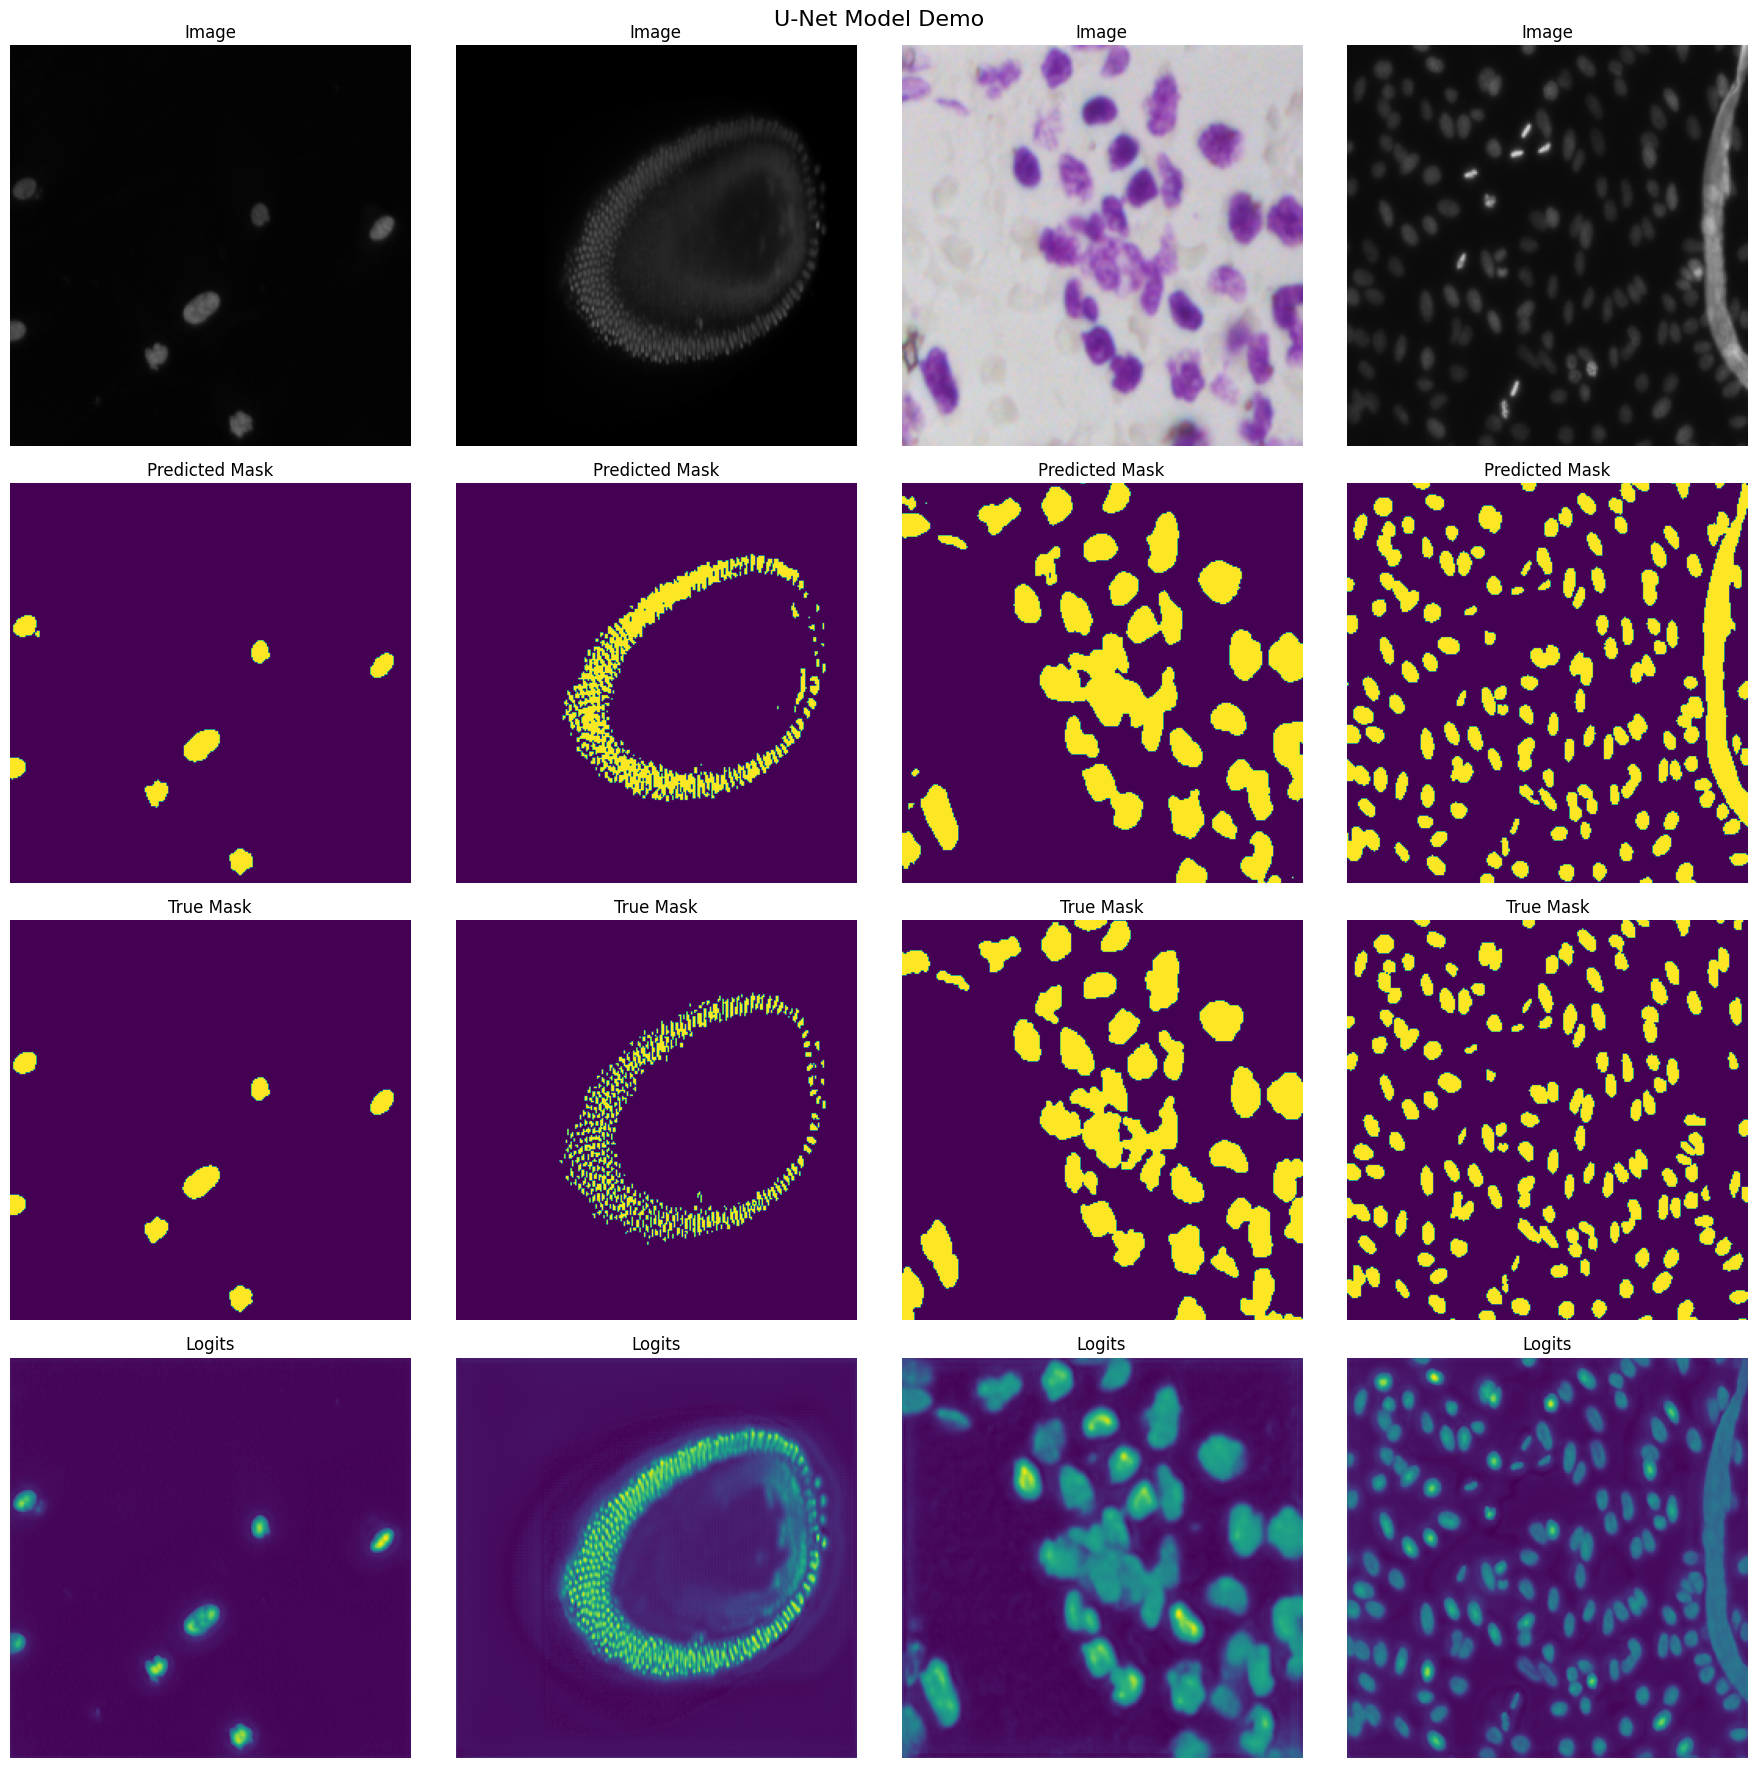

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
imgs, masks = get_img_mask()

title = 'U-Net Model Demo' if isinstance(model, UNet) else 'DeepLab V3+ Model Demo'
fig.suptitle(title, fontsize=16)

for i in range(4):
    pred_dict = model.predict(imgs[i])    
    pred = pred_dict['pred']
    img = pred_dict['img']
    logits = pred_dict['logits']
    true_mask = masks[i].cpu().numpy().transpose(1, 2, 0)
    
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title('Image')
    
    axs[1, i].imshow(pred)
    axs[1, i].axis('off')
    axs[1, i].set_title('Predicted Mask')
    
    axs[2, i].imshow(true_mask)
    axs[2, i].axis('off')
    axs[2, i].set_title('True Mask')
    
    axs[3, i].imshow(logits)
    axs[3, i].axis('off')
    axs[3, i].set_title('Logits')
    
plt.tight_layout()
plt.show()